# Подключение библиотек

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import interpolate

# EM-алгоритм

In [4]:
class EMAlgorithm:
    def __init__(self, num_components=2, max_iters=100, tol=1e-6):
        self.num_components = num_components
        self.max_iters = max_iters
        self.tol = tol

    def gaussian_pdf(self, x, mean, std_dev):
        return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    #вычисление мат ожидания скрытых параметров
    def step_e(self, X, means, std_devs, weights):
        n = len(X)
        responsibilities = np.zeros((n, self.num_components))
        
        for i in range(self.num_components):
            responsibilities[:, i] = weights[i] * self.gaussian_pdf(X, means[i], std_devs[i])
            
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        
        return responsibilities
    #максимизация логарифма правдоподобия
    def step_m(self, X, responsibilities):
        n = len(X)
        means = np.zeros(self.num_components)
        std_devs = np.zeros(self.num_components)
        weights = np.zeros(self.num_components)
        
        for i in range(self.num_components):
            # Обновление веса компоненты
            weight = responsibilities[:, i].sum()
            weights[i] = weight / n
            
            # Обновление среднего компоненты
            means[i] = (responsibilities[:, i] * X).sum() / weight
            
            # Обновление стандартного отклонения компоненты
            std_devs[i] = np.sqrt((responsibilities[:, i] * (X - means[i]) ** 2).sum() / weight)
        
        return means, std_devs, weights

    def fit(self, X):
        n = len(X)
        
        # Инициализация параметров (среднее, стандартное отклонение и веса компонент)
        np.random.seed(42)
        means = np.random.choice(X, self.num_components)  # Начальные средние
        std_devs = np.random.random(self.num_components) + 0.5  # Начальные стандартные отклонения
        weights = np.ones(self.num_components) / self.num_components  # Начальные веса
        
        log_likelihood_old = 0
        
        for iteration in range(self.max_iters):
            # Шаг E: вычисление вероятности принадлежности
            responsibilities = self.step_e(X, means, std_devs, weights)
            
            # Шаг M: обновление параметров модели
            means, std_devs, weights = self.step_m(X, responsibilities)
            
            # Вычисление логарифма функции правдоподобия
            log_likelihood_new = np.sum(np.log(np.sum(responsibilities * weights, axis=1)))
            
            # Проверка на сходимость
            if np.abs(log_likelihood_new - log_likelihood_old) < self.tol:
                print(f'Got convergent on iter {iteration + 1}')
                break
            
            log_likelihood_old = log_likelihood_new
        
        self.means = means
        self.std_devs = std_devs
        self.weights = weights
        return means, std_devs, weights

Got convergent on iter 99


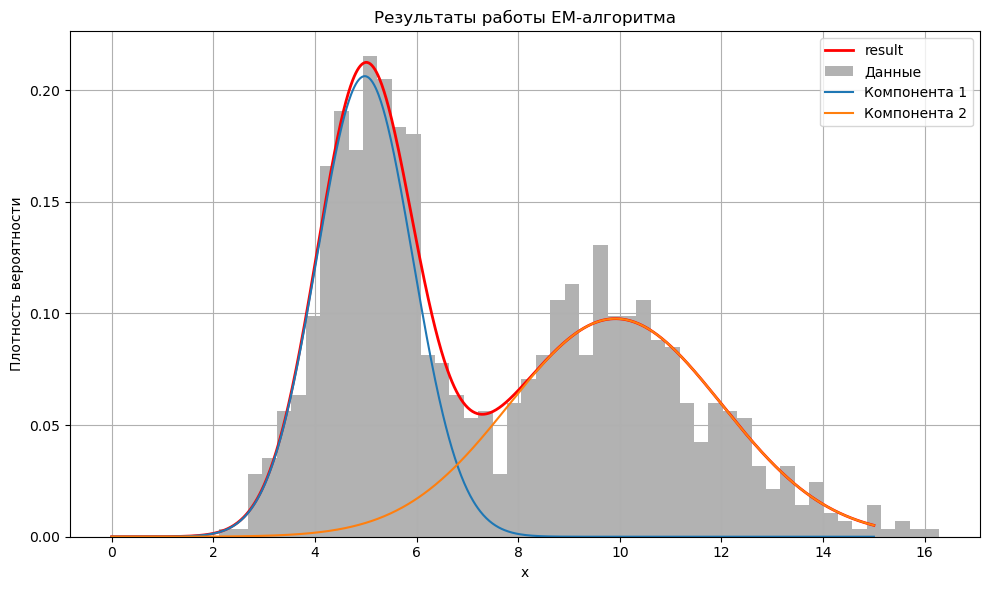

In [5]:
X = np.concatenate([np.random.normal(5, 1, 500), np.random.normal(10, 2, 500)])

em_model = EMAlgorithm(num_components=2, max_iters=100, tol=1e-6)
means, std_devs, weights = em_model.fit(X)

plt.figure(figsize=(10, 6))

x_vals = np.linspace(0, 15, 1000)
y_vals = sum(weights[i] * em_model.gaussian_pdf(x_vals, means[i], std_devs[i]) for i in range(len(means)))
plt.plot(x_vals, y_vals, label="result", color='r', linewidth=2)

plt.hist(X, bins=50, density=True, alpha=0.6, color='gray', label="Данные")

for i in range(len(means)):
    plt.plot(x_vals, weights[i] * em_model.gaussian_pdf(x_vals, means[i], std_devs[i]), label=f'Компонента {i+1}')
    
plt.title("Результаты работы EM-алгоритма")
plt.xlabel("x")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Алгоритм ядерного сглаживания

In [7]:
def gaussian_kernel(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

def triangular_kernel(u):
    return (1 - np.abs(u)) * (np.abs(u) <= 1)

def laplace_kernel(u):
    return 0.5 * np.exp(-np.abs(u))

In [8]:
def kernel_density_estimate(data, points, kernel, bandwidth):
    n = len(data)
    densities = np.zeros_like(points)
    i = 0 
    for point in points:
        kernel_sum = np.sum(kernel((point - data) / bandwidth))
        densities[i] = kernel_sum / (n * bandwidth)
        i+=1
    return densities

# Генерация тестовых данных
# np.random.seed(42)
data = np.random.normal(0, 1, size=100)  # 100 точек из нормального распределения

# Задаем сетку для оценки плотности
x_points = np.linspace(-4, 4, 1000)  # точки, где будем оценивать плотность

# Оцениваем плотность для разных значений ширины окна
bandwidths = [0.1, 0.5, 1.0]

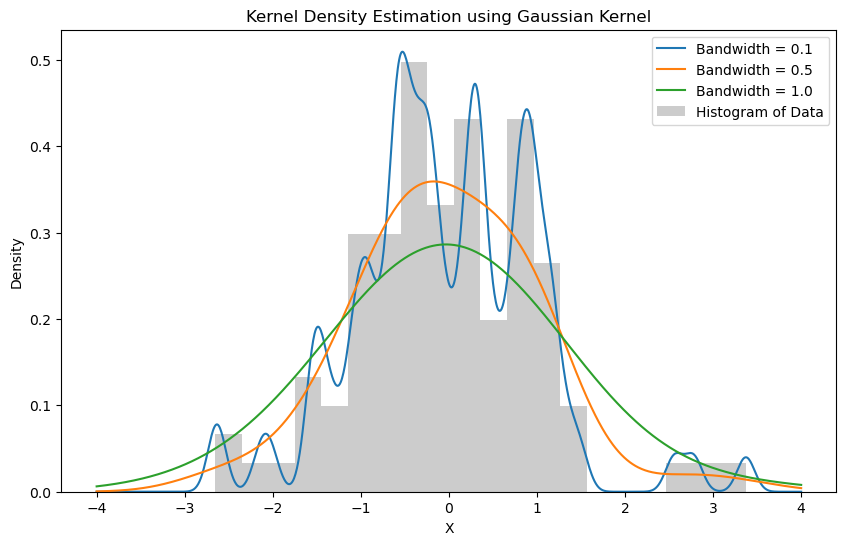

In [9]:
# Визуализация результатов
plt.figure(figsize=(10, 6))

for bw in bandwidths:
    density = kernel_density_estimate(data, x_points, gaussian_kernel, bw)
    plt.plot(x_points, density, label=f"Bandwidth = {bw}")

# Добавляем гистограмму данных
plt.hist(data, bins=20, density=True, alpha=0.4, color='gray', label='Histogram of Data')
plt.title("Kernel Density Estimation using Gaussian Kernel")
plt.xlabel("X")
plt.ylabel("Density")
plt.legend()
plt.show()

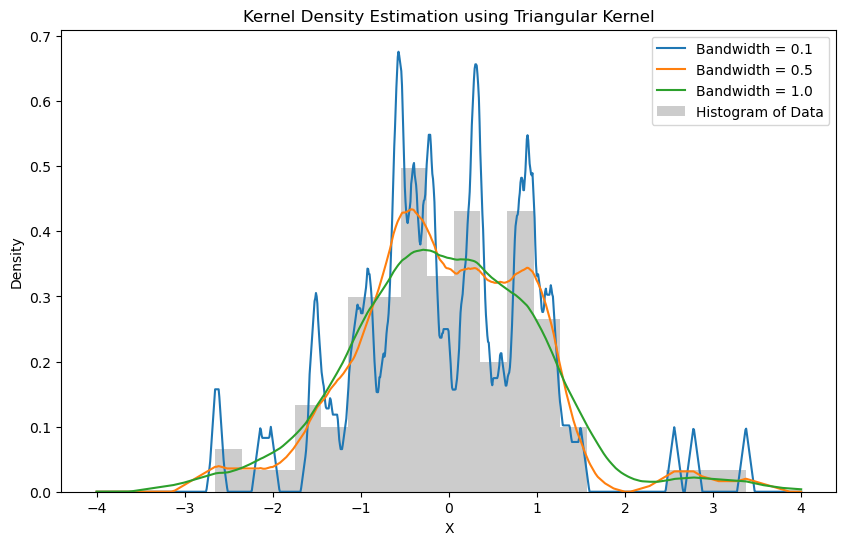

In [10]:
# Визуализация результатов
plt.figure(figsize=(10, 6))

for bw in bandwidths:
    density = kernel_density_estimate(data, x_points, triangular_kernel, bw)
    plt.plot(x_points, density, label=f"Bandwidth = {bw}")

# Добавляем гистограмму данных
plt.hist(data, bins=20, density=True, alpha=0.4, color='gray', label='Histogram of Data')
plt.title("Kernel Density Estimation using Triangular Kernel")
plt.xlabel("X")
plt.ylabel("Density")
plt.legend()
plt.show()

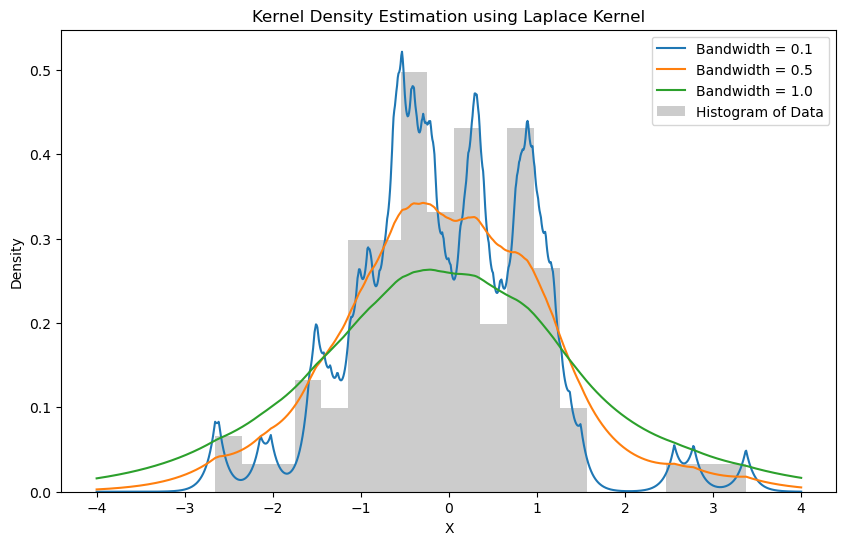

In [11]:
# Визуализация результатов
plt.figure(figsize=(10, 6))

for bw in bandwidths:
    density = kernel_density_estimate(data, x_points, laplace_kernel, bw)
    plt.plot(x_points, density, label=f"Bandwidth = {bw}")

# Добавляем гистограмму данных
plt.hist(data, bins=20, density=True, alpha=0.4, color='gray', label='Histogram of Data')
plt.title("Kernel Density Estimation using Laplace Kernel")
plt.xlabel("X")
plt.ylabel("Density")
plt.legend()
plt.show()

Можно сделать вывод, что не столь важно ядро, т.к. оно определяет гладкость, как ширина окна, т.к. именно она регулирует количество поступивших данных.

# Метод Метрополиса-Гастингса

In [14]:
# Целевое распределение: Логнормальное распределение
def target_distribution(x):
    return (1 / (x * np.sqrt(2 * np.pi * 0.2))) * np.exp(-0.5 * ((np.log(x) - 0.5) ** 2) / 0.2)

# Предложенное распределение (например, равномерное распределение)
def proposal_distribution():
    return np.random.uniform(0.1, 15)

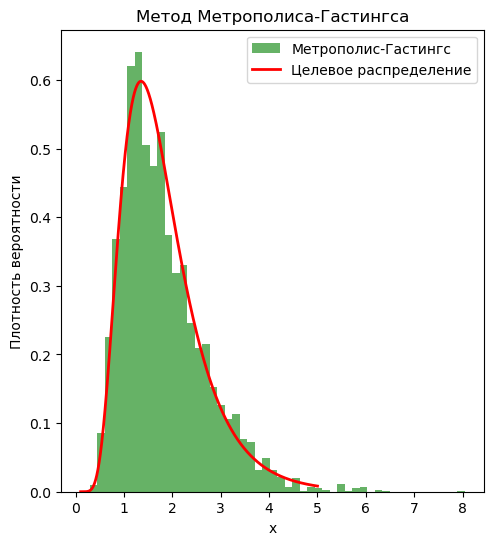

In [15]:
# Метод Метрополиса-Гастингса
def metropolis_hastings(target, proposal, num_samples):
    samples = []
    x_current = proposal()  # Начальное значение (генерация первого кандидата)
    
    for _ in range(num_samples):
        x_proposed = proposal()  # Генерация нового кандидата
        acceptance_ratio = target(x_proposed) / target(x_current)  # Отношение вероятностей

        if np.random.rand() < acceptance_ratio:  # Принятие нового кандидата
            x_current = x_proposed
        
        samples.append(x_current)
    
    return np.array(samples)

# Генерация выборки с использованием обоих методов
num_samples = 10000
metropolis_samples = metropolis_hastings(target_distribution, proposal_distribution, num_samples)
# Визуализация результатов
x_vals = np.linspace(0.1, 5, 1000)
y_vals = target_distribution(x_vals)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(metropolis_samples, bins=50, density=True, alpha=0.6, color='g', label="Метрополис-Гастингс")
plt.plot(x_vals, y_vals, label="Целевое распределение", color='r', linewidth=2)
plt.title("Метод Метрополиса-Гастингса")
plt.xlabel("x")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.show()


# Метод Гиббса

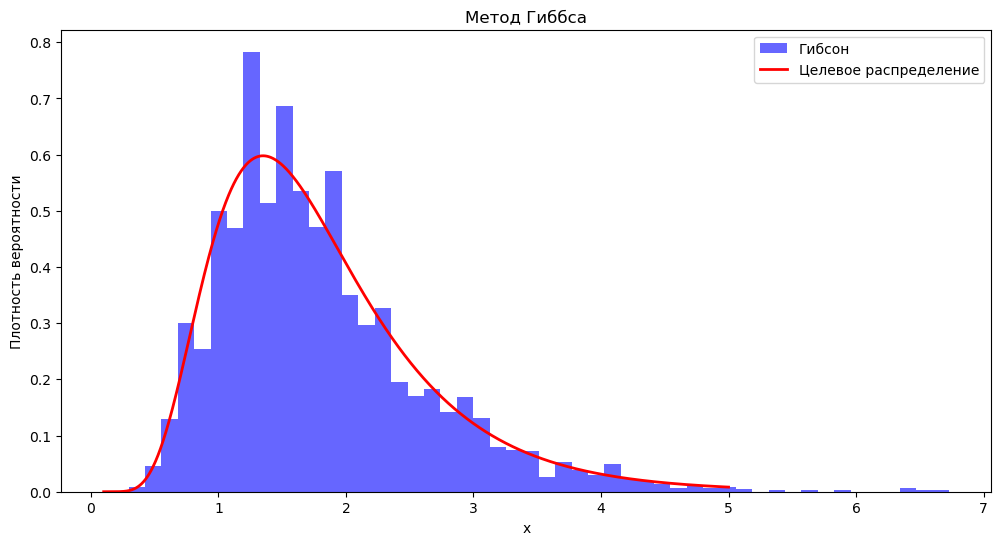

In [17]:
def gibbs_sampler(target, proposal, num_samples):
    samples = []
    x_current = proposal()
    
    for _ in range(num_samples):
        x_proposed = proposal()
        
        acceptance_ratio = min(1, target(x_proposed) / target(x_current))
        
        # Если кандидат принят, обновляем текущее состояние
        if np.random.rand() < acceptance_ratio:
            x_current = x_proposed
        
        samples.append(x_current)
    
    return np.array(samples)

gibbs_samples = gibbs_sampler(target_distribution, proposal_distribution, num_samples)
x_vals = np.linspace(0.1, 5, 1000)
y_vals = target_distribution(x_vals)

plt.figure(figsize=(12, 6))
plt.hist(gibbs_samples, bins=50, density=True, alpha=0.6, color='b', label="Гибсон")
plt.plot(x_vals, y_vals, label="Целевое распределение", color='r', linewidth=2)
plt.title("Метод Гиббса")
plt.xlabel("x")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.show()

# Картина для сравнения

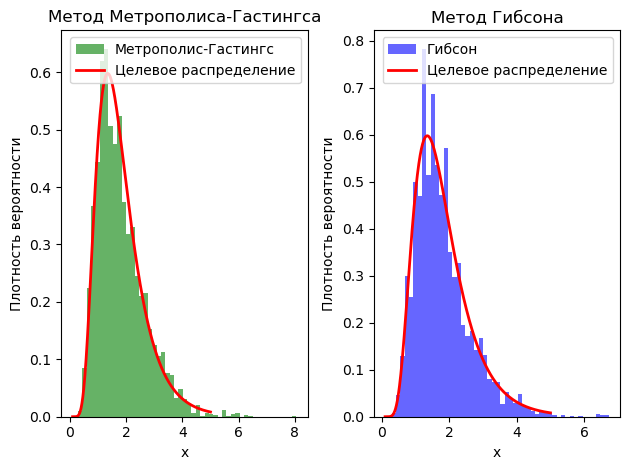

In [19]:
# Гистограмма выборки Метрополиса-Гастингса
plt.subplot(1, 2, 1)
plt.hist(metropolis_samples, bins=50, density=True, alpha=0.6, color='g', label="Метрополис-Гастингс")
plt.plot(x_vals, y_vals, label="Целевое распределение", color='r', linewidth=2)
plt.title("Метод Метрополиса-Гастингса")
plt.xlabel("x")
plt.ylabel("Плотность вероятности")
plt.legend()

# Гистограмма выборки Гибсона
plt.subplot(1, 2, 2)
plt.hist(gibbs_samples, bins=50, density=True, alpha=0.6, color='b', label="Гибсон")
plt.plot(x_vals, y_vals, label="Целевое распределение", color='r', linewidth=2)
plt.title("Метод Гибсона")
plt.xlabel("x")
plt.ylabel("Плотность вероятности")
plt.legend()

plt.tight_layout()
plt.show()

# Семплирование на восстановленной плотности

In [21]:
X = np.concatenate([np.random.normal(5, 1, 500), np.random.normal(10, 2, 500)])
x_vals = np.linspace(0, 15, 1000)
kde_density = kernel_density_estimate(X, x_vals, gaussian_kernel, 0.5)


em_density= sum(weights[i] * em_model.gaussian_pdf(x_vals, means[i], std_devs[i]) for i in range(len(means)))

## Интерполяция (прошу пощады)

Got convergent on iter 91


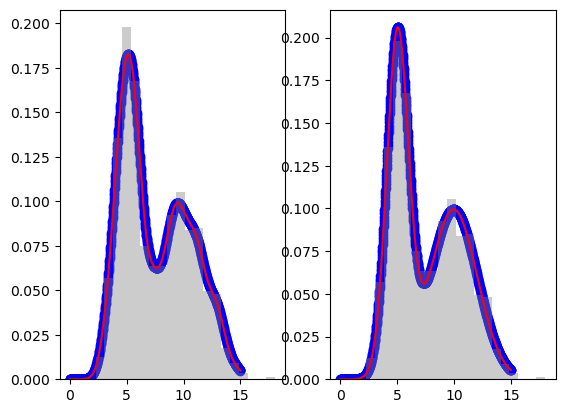

In [23]:
X = np.concatenate([np.random.normal(5, 1, 500), np.random.normal(10, 2, 500)])
x_vals = np.linspace(0, 15, 1000)
kde_density = kernel_density_estimate(X, x_vals, gaussian_kernel, 0.5)

em_model = EMAlgorithm(num_components=2, max_iters=100, tol=1e-6)
means, std_devs, weights = em_model.fit(X)
em_density = sum(weights[i] * em_model.gaussian_pdf(x_vals, means[i], std_devs[i]) for i in range(len(means)))

x_line = np.linspace(min(x_vals), max(x_vals), 1000)

kde_density_smooth = interpolate.CubicSpline(x_vals, kde_density)
kde_density_smooth_line = kde_density_smooth(x_line)

em_density_smooth = interpolate.CubicSpline(x_vals, em_density)
em_density_smooth_line = em_density_smooth(x_line)


plt.subplot(1, 2, 1)
plt.scatter(x_vals, kde_density, label="Исходные данные", color="blue")
plt.plot(x_line, kde_density_smooth_line , label="Интерполяция (Кубический сплайн)", color="red")
plt.hist(X, bins=20, density=True, alpha=0.4, color='gray', label='Histogram of Data')

plt.subplot(1, 2, 2)
plt.scatter(x_vals, em_density, label="Исходные данные", color="blue")
plt.plot(x_line, em_density_smooth_line , label="Интерполяция (Кубический сплайн)", color="red")
plt.hist(X, bins=20, density=True, alpha=0.4, color='gray', label='Histogram of Data')

plt.show()

# Ядерное сглаживание + метод Метрополиса-Гастингса

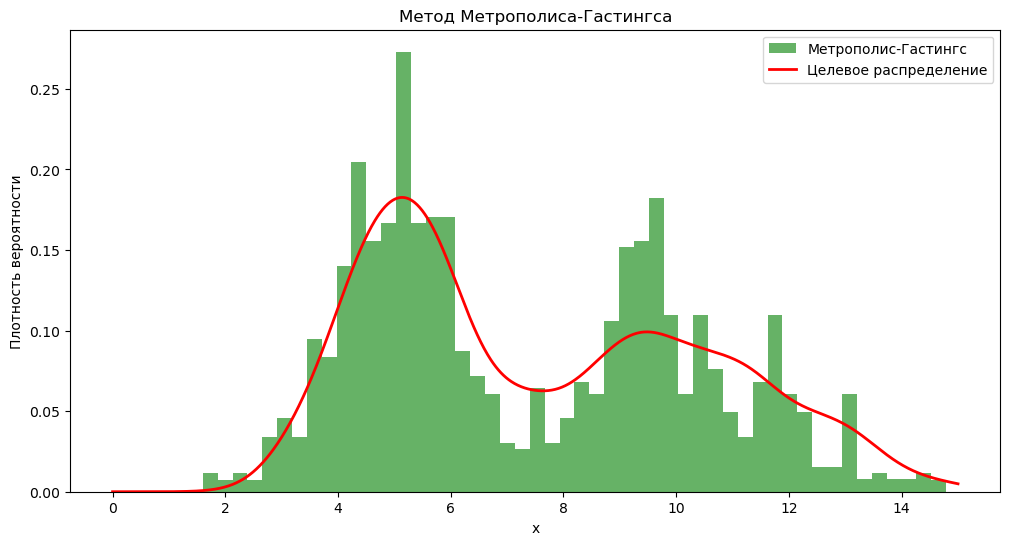

In [25]:
num_samples = 1000
metropolis_samples = metropolis_hastings(kde_density_smooth, proposal_distribution, num_samples)
# Визуализация результатов
x_vals = np.linspace(0, 15, 1000)
y_vals = kde_density_smooth(x_vals)


plt.figure(figsize=(12, 6))
plt.hist(metropolis_samples, bins=50, density=True, alpha=0.6, color='g', label="Метрополис-Гастингс")
plt.plot(x_vals, y_vals, label="Целевое распределение", color='r', linewidth=2)
plt.title("Метод Метрополиса-Гастингса")
plt.xlabel("x")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.show()


# EM-алгоритм + метод Гиббса

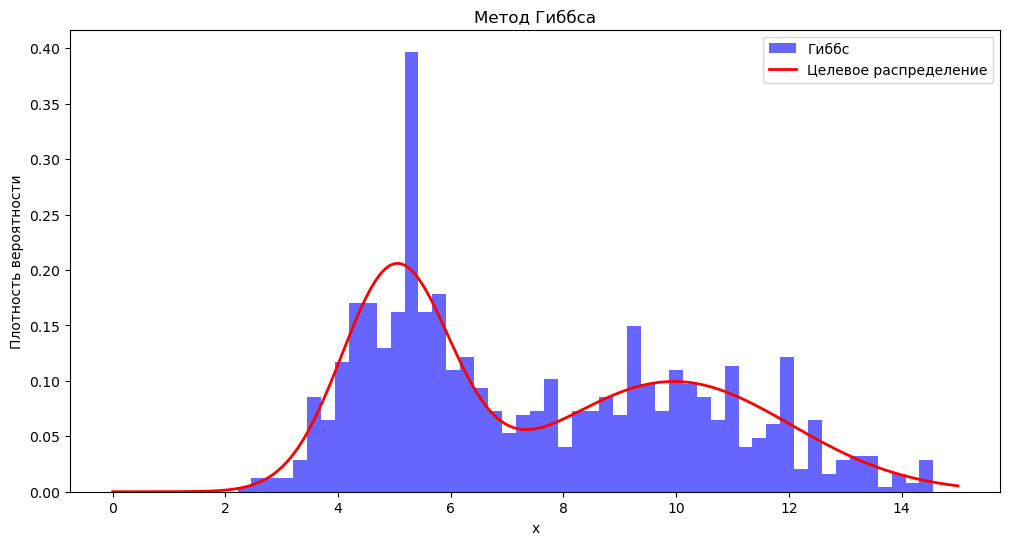

In [27]:
gibbs_samples = gibbs_sampler(em_density_smooth, proposal_distribution, num_samples)
x_vals = np.linspace(0, 15, 1000)
y_vals = em_density_smooth(x_vals)

plt.figure(figsize=(12, 6))
plt.hist(gibbs_samples, bins=50, density=True, alpha=0.6, color='b', label="Гиббс")
plt.plot(x_vals, y_vals, label="Целевое распределение", color='r', linewidth=2)
plt.title("Метод Гиббса")
plt.xlabel("x")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.show()

# Расстояние

In [29]:
def kullback_leibler_divergence(p, q):
    #Во избежание деления на 0
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    
    return np.sum(p * np.log(p / q))

In [30]:
def get_and_plot_kl_div(hist1, hist2, bins=50):
    kl_divergence = kullback_leibler_divergence(hist1, hist2)
    print(f"Расстояние Кульбака-Лейблера между двумя распределениями: {kl_divergence:.4f}")
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Центры бинов
    
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, hist1, width=bin_edges[1] - bin_edges[0], alpha=0.5, label="Распределение 1")
    plt.bar(bin_centers, hist2, width=bin_edges[1] - bin_edges[0], alpha=0.5, label="Распределение 2")
    plt.title("Сравнение двух распределений")
    plt.xlabel("Значения")
    plt.ylabel("Плотность вероятности")
    plt.legend()
    plt.show()

## Между ядерным сглаживанием с последующим методом Метрополиса-Гастингса и оригинальным набором точек

Расстояние Кульбака-Лейблера между двумя распределениями: 0.4156


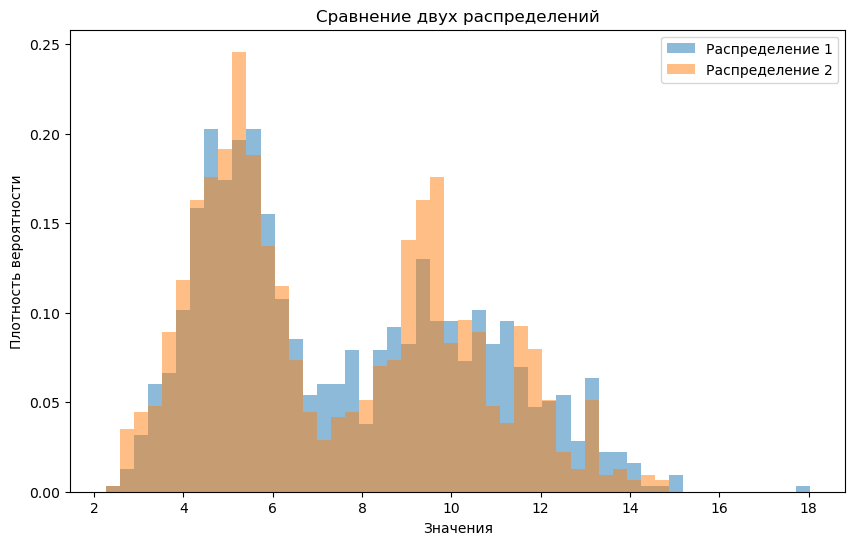

In [32]:
bins=50
hist1, bin_edges = np.histogram(X, bins=bins, density=True)
hist2, _ = np.histogram(metropolis_samples, bins=bin_edges, density=True)

get_and_plot_kl_div(hist1, hist2)

## Между EM-алгоритмом с последующим семплированием по методу Гиббса и оригинальным набором данных

Расстояние Кульбака-Лейблера между двумя распределениями: 0.3800


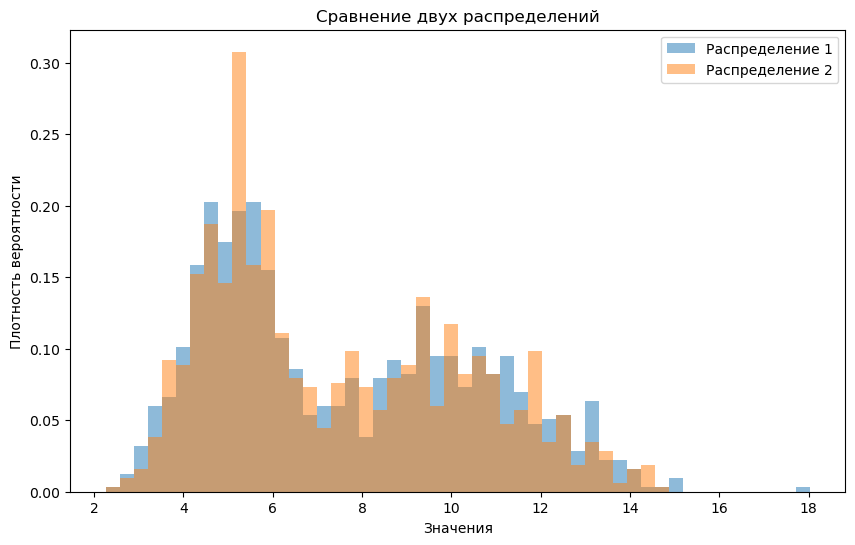

In [34]:
bins=50
hist1, bin_edges = np.histogram(X, bins=bins, density=True)
hist2, _ = np.histogram(gibbs_samples, bins=bin_edges, density=True)

get_and_plot_kl_div(hist1, hist2)

# Выводы

На основе проведенных исследований можно сделать следующие выводы:
1) Реализованы алгоритмы восстановления плотности вероятности: EM-алгоритм и алгоритм ядерного сглаживания;
2) Реализованы алгоритмы сэмлпирования данных: метод Метрополиса-Гастингса и метод Гиббса;
3) Проведен сравнительный анализ комбинаций методов сэмплирования и алгоритмов восстановления плотности вероятности;
4) Проведен расчет расстояния Кульбака-Лейблера для предыдущего сравнительного анализа.